Name: Charles Fawcett

Student ID: 14247617

In [29]:
#ALL import statements
import numpy as np
import pandas as pd
import apmodule as ap
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

In [30]:
#ALL custom functions

def quartile_performance(data: pd.DataFrame, return_name: str = "fut_ret") -> pd.DataFrame:
    mean_return = data[return_name].mean()*12
    volatility = data[return_name].std()*np.sqrt(12)
    rr_ratio = (data[return_name].mean()*12) / data[return_name].std()*np.sqrt(12)
    performance = pd.DataFrame({'Mean Ret': mean_return,
                                'Std Dev': volatility,
                                'RR Ratio': rr_ratio})
    return performance

def one_dollar_invested_plot(df: pd.DataFrame, title: str, legend_map: dict, save_as: None | str = None) -> None:
    ax = df.plot(figsize=(10, 6))
    ax.set_yscale('log')
    ax.set_title(title)
    ax.set_xlabel("Date")
    ax.set_ylabel("Portfolio Value ($, Log Scale)")
    ax.set_axisbelow(True)
    ax.yaxis.set_major_locator(mticker.LogLocator(base=10))
    ax.yaxis.set_minor_locator(mticker.LogLocator(base=10, subs=np.arange(2,10)*0.1))
    ax.grid(True, axis='y', linestyle=':', linewidth=1.2, alpha=0.75)
    ax.grid(True, axis='y', which='minor', linestyle=':', linewidth=0.6, alpha=0.65)
    ax.tick_params(axis='x', labelrotation=0)
    for lbl in ax.get_xticklabels():
        lbl.set_ha('center')
    ax.figure.tight_layout()

    # remap legend labels
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, [legend_map.get(l, l) for l in labels])

    if save_as:
        ax.figure.savefig(save_as, dpi=150, bbox_inches='tight')
    plt.show()
    plt.close(ax.figure)

    

In [31]:
#Loading of ALL data files
factors = pd.read_csv('FACTORS.zip', parse_dates=['date']).set_index(['id', 'date'])
market_cap = pd.read_csv('Market_cap.zip', parse_dates=['date']).set_index(['id', 'date'])
names = pd.read_csv('names.zip').set_index('id')
prices = pd.read_csv('Prices.zip', parse_dates=['date']).set_index(['id', 'date'])

factors.head()

tvol    profit    safety
id    date                                    
10001 1996-07-31  1.145514 -0.612134 -0.475430
      1996-08-30  1.144505 -0.614493 -0.553341
      1996-09-30  1.144190 -1.327119 -0.697980
      1996-10-31  1.124252 -1.324461 -0.728012
      1996-11-29  1.123180 -1.321322 -0.721799

1. PREDICTIVE POWER OF INVESTMENT FACTORS


In [32]:
#calculating the future returns and storing this in a series
future_returns = np.log(prices['price'].groupby('id').shift(-1) / prices['price']).rename('fut_ret')

#split each factor into their own series
tvol_series = factors['tvol']
profit_series = factors['profit']
safety_series = factors['safety']

#merge each factor series with the future returns
tvol_data = tvol_series.to_frame().join(future_returns).dropna()
profit_data = profit_series.to_frame().join(future_returns).dropna()
safety_data = safety_series.to_frame().join(future_returns).dropna()

#number of bins for the quintile analysis
N = 4

#create the bins
tvol_data['tvol_group'] = tvol_data.groupby('date', group_keys=False)['tvol'].apply(lambda x: pd.qcut(x,N, labels=False))+1
profit_data['profit_group'] = profit_data.groupby('date', group_keys=False)['profit'].apply(lambda x: pd.qcut(x,N, labels=False))+1
safety_data['safety_group'] = safety_data.groupby('date', group_keys=False)['safety'].apply(lambda x: pd.qcut(x,N, labels=False))+1

#combine into one dataframe
groups = pd.concat(
    [tvol_data[['tvol_group']], profit_data[['profit_group']], safety_data[['safety_group']]],
    axis=1, join='inner'
)
data = groups.join(future_returns).dropna(subset=['fut_ret'])

data.tail()

tvol_group  profit_group  safety_group   fut_ret
id    date                                                        
93426 2023-08-31           3             3             4 -0.070144
      2023-09-29           3             3             4 -0.115403
      2023-10-31           3             3             4  0.018872
      2023-11-30           3             3             4  0.111019
      2023-12-29           3             3             4 -0.066438

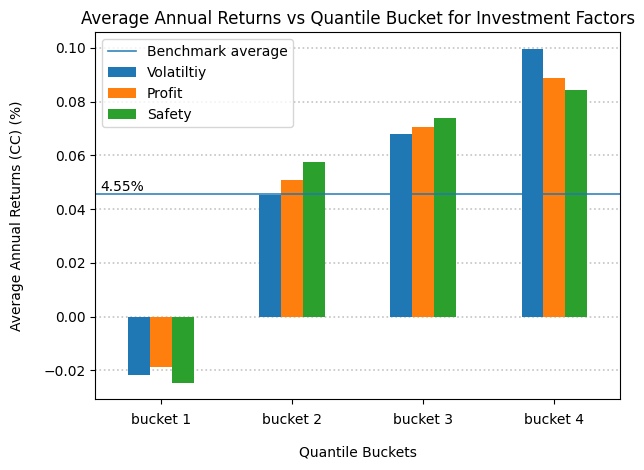

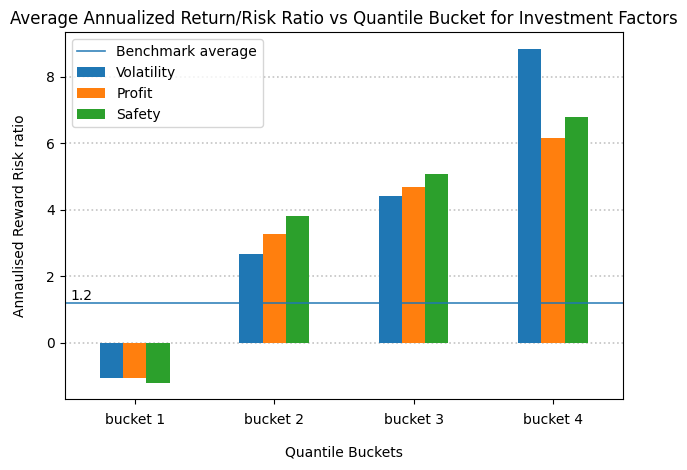

In [33]:
#calculate the average signal and the average future return and pass this to the quartile_performance function
tvol_perf = quartile_performance(tvol_data.groupby(['date', 'tvol_group']).mean().unstack(level=1))
profit_perf = quartile_performance(profit_data.groupby(['date', 'profit_group']).mean().unstack(level=1))
safety_perf = quartile_performance(safety_data.groupby(['date', 'safety_group']).mean().unstack(level=1))

#setup and creating the "Average Annual Returns vs Quantile Bucket for Investment Factors" graph (aar) ###########################################
#benchmark performance (using tvol)
avg_benchmark_returns = tvol_data['fut_ret'].mean()*12
benchmark_rr_ratio = (tvol_data['fut_ret'].mean()*12) / tvol_data['fut_ret'].std()*np.sqrt(12)

bar_chart_col_names = [f"bucket {i+1}" for i in range(N)]
aar_bar_chart_df = pd.DataFrame({
    'Volatiltiy': tvol_perf['Mean Ret'],
    'Profit': profit_perf['Mean Ret'],
    'Safety': safety_perf['Mean Ret']
})

aar_bar_chart_df.index = bar_chart_col_names

aar_bar_chart = aar_bar_chart_df.plot(kind='bar', rot=0)
aar_bar_chart.set_xlabel("Quantile Buckets", labelpad=14)
aar_bar_chart.set_ylabel("Average Annual Returns (CC) (%)", labelpad=14)
aar_bar_chart.set_title("Average Annual Returns vs Quantile Bucket for Investment Factors")

aar_bar_chart.axhline(y=avg_benchmark_returns, linestyle='-', linewidth=1.2, alpha=0.9, label='Benchmark average')
aar_bar_chart.text(0.01, avg_benchmark_returns, f'{avg_benchmark_returns:.2%}',
        transform=aar_bar_chart.get_yaxis_transform(),
        ha='left', va='bottom', clip_on=False)
aar_bar_chart.legend()

aar_bar_chart.set_axisbelow(True)
aar_bar_chart.grid(True, axis='y', linestyle=':', linewidth=1.2, alpha=0.75)
for lbl in aar_bar_chart.get_xticklabels():
    lbl.set_ha('center')   # default for bars, but explicit is fine
aar_bar_chart.tick_params(axis='x', pad=6)  # a little space from the axis
aar_bar_chart.figure.tight_layout()

#setup and creating the "Risk to Reward ratio vs Quintile Bucket for Investment Factors" (rrr)
rrr_bar_chart = pd.DataFrame({
    'Volatility': tvol_perf['RR Ratio'],
    'Profit': profit_perf['RR Ratio'],
    'Safety': safety_perf['RR Ratio']
})

rrr_bar_chart.index = bar_chart_col_names

rrr_bar_chart = rrr_bar_chart.plot(kind='bar', rot=0)
rrr_bar_chart.set_xlabel("Quantile Buckets", labelpad=14)
rrr_bar_chart.set_ylabel("Annaulised Reward Risk ratio", labelpad=14)
rrr_bar_chart.set_title("Average Annualized Return/Risk Ratio vs Quantile Bucket for Investment Factors")

rrr_bar_chart.axhline(y=benchmark_rr_ratio, linestyle='-', linewidth=1.2, alpha=0.9, label='Benchmark average')
rrr_bar_chart.text(0.01, benchmark_rr_ratio, f'{benchmark_rr_ratio:.2}',
        transform=rrr_bar_chart.get_yaxis_transform(),
        ha='left', va='bottom', clip_on=False)
rrr_bar_chart.legend()

rrr_bar_chart.set_axisbelow(True)
rrr_bar_chart.grid(True, axis='y', linestyle=':', linewidth=1.2, alpha=0.75)
for lbl in rrr_bar_chart.get_xticklabels():
    lbl.set_ha('center')
rrr_bar_chart.tick_params(axis='x', pad=6)
rrr_bar_chart.figure.tight_layout()



In [34]:
data.head()

tvol_group  profit_group  safety_group   fut_ret
id    date                                                        
10001 1996-07-31           4             1             2  0.037458
      1996-08-30           4             1             2  0.040916
      1996-09-30           4             1             1 -0.028987
      1996-10-31           4             1             1  0.028988
      1996-11-29           4             1             1 -0.061268

In [35]:
#now let's visualise the returns on a $1 portfolio in each bucket and factor
bench_port = data['fut_ret'].groupby('date').mean().cumsum().apply(np.exp).to_frame()
tvol_port = data.groupby(['date', 'tvol_group']).mean().unstack(level=1)['fut_ret'].cumsum().apply(np.exp)
tvol_port = tvol_port.join(bench_port)
safety_port = data.groupby(['date', 'safety_group']).mean().unstack(level=1)['fut_ret'].cumsum().apply(np.exp)
safety_port = safety_port.join(bench_port)
profit_port = data.groupby(['date', 'profit_group']).mean().unstack(level=1)['fut_ret'].cumsum().apply(np.exp)
profit_port = profit_port.join(bench_port)

legend_map = {}
for i in range(0, N):
    legend_map[f"{i+1}"] = f"Bucket {i+1}"
legend_map["fut_ret"] = "Benchmark"

#plot each factor
# one_dollar_invested_plot(tvol_port, "Growth Of $1 Invested In Quantiles Split On Volatility Factor", legend_map)
# one_dollar_invested_plot(safety_port, "Growth Of $1 Invested In Quantiles Split On Safety Factor", legend_map)
# one_dollar_invested_plot(profit_port, "Growth Of $1 Invested In Quantiles Split On Profit Factor", legend_map)

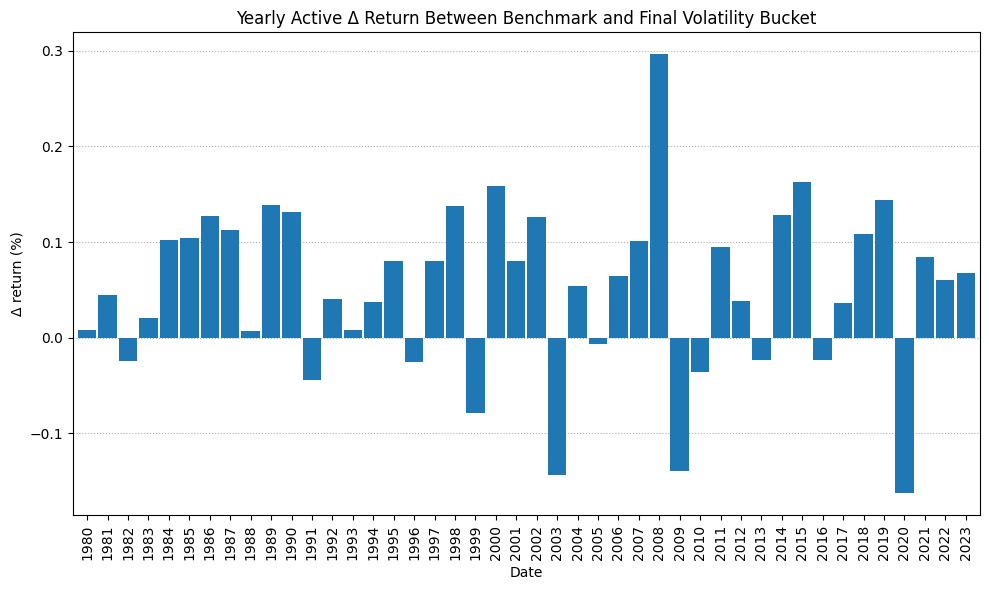

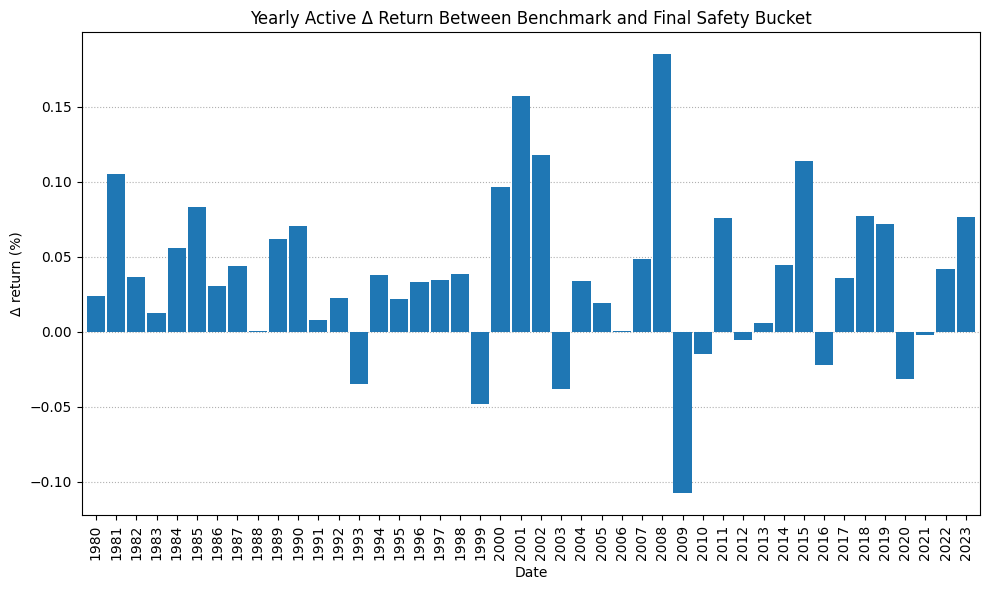

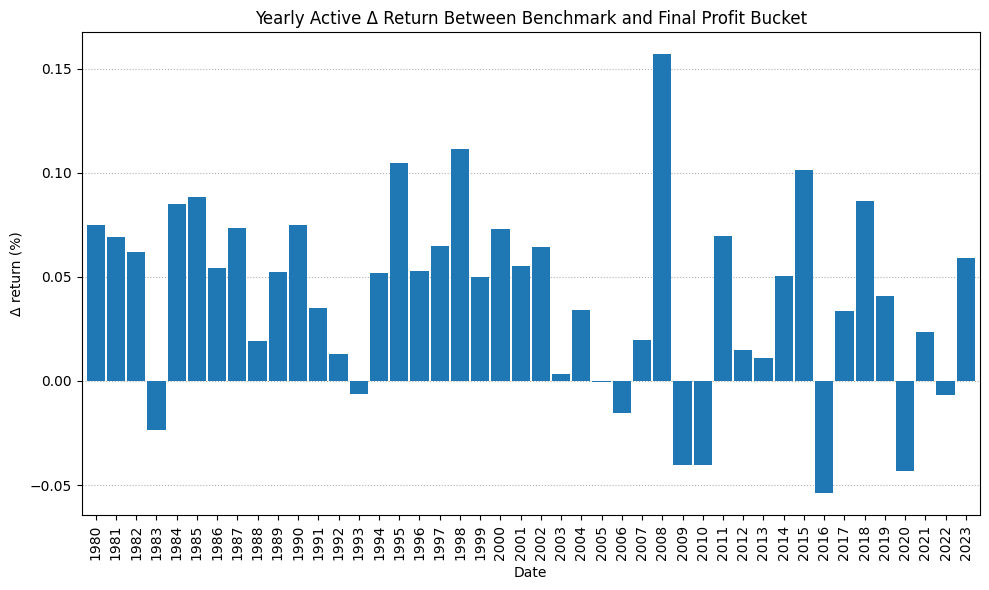

In [36]:
#let's take a closer look at the year by year performance by looking at the differnce between bucket 4 and the benchmark year by year for each factor

benchmark_ret = data['fut_ret'].groupby('date').mean().to_frame()

#yby for year by year
tvol_active = data.groupby(['date', 'tvol_group']).mean().unstack(level=1)["fut_ret"]
tvol_active = tvol_active.join(benchmark_ret).dropna()
tvol_active["active"] = tvol_active[N] - tvol_active["fut_ret"]
tvol_yby = tvol_active.resample('YE').sum()
tvol_yby.index = tvol_yby.index.year

safety_active = data.groupby(['date', 'safety_group']).mean().unstack(level=1)["fut_ret"]
safety_active = safety_active.join(benchmark_ret).dropna()
safety_active["active"] = safety_active[N] - safety_active["fut_ret"]
safety_yby = safety_active.resample('YE').sum()
safety_yby.index = safety_yby.index.year

profit_active = data.groupby(['date', 'profit_group']).mean().unstack(level=1)["fut_ret"]
profit_active = profit_active.join(benchmark_ret).dropna()
profit_active["active"] = profit_active[N] - profit_active["fut_ret"]
profit_yby = profit_active.resample('YE').sum()
profit_yby.index = profit_yby.index.year

#take the active returns and put them in a dataframe for future use
actives = pd.DataFrame()
actives["tvol"] = tvol_active['active'] 
actives["safety"] = safety_active['active'] 
actives["profit"] = profit_active['active'] 

#bar charts
tvol_yby_bar_return = tvol_yby['active'].plot(figsize=(10,6), kind='bar', width=0.9)
tvol_yby_bar_return.set_title("Yearly Active Δ Return Between Benchmark and Final Volatility Bucket")
tvol_yby_bar_return.set_xlabel("Date")
tvol_yby_bar_return.set_ylabel("Δ return (%)")
tvol_yby_bar_return.grid(True, axis='y', linestyle=':', linewidth=0.8)
tvol_yby_bar_return.set_axisbelow(True)
plt.tight_layout()
plt.show()

safety_yby_bar_return = safety_yby['active'].plot(figsize=(10,6), kind='bar', width=0.9)
safety_yby_bar_return.set_title("Yearly Active Δ Return Between Benchmark and Final Safety Bucket")
safety_yby_bar_return.set_xlabel("Date")
safety_yby_bar_return.set_ylabel("Δ return (%)")
safety_yby_bar_return.grid(True, axis='y', linestyle=':', linewidth=0.8)
safety_yby_bar_return.set_axisbelow(True)
plt.tight_layout()
plt.show()

profit_yby_bar_return = profit_yby['active'].plot(figsize=(10,6), kind='bar', width=0.9)
profit_yby_bar_return.set_title("Yearly Active Δ Return Between Benchmark and Final Profit Bucket")
profit_yby_bar_return.set_xlabel("Date")
profit_yby_bar_return.set_ylabel("Δ return (%)")
profit_yby_bar_return.grid(True, axis='y', linestyle=':', linewidth=0.8)
profit_yby_bar_return.set_axisbelow(True)
plt.tight_layout()
plt.show()




In [ ]:
#now to calculate the correlation between the factors!

roll_36_tvol_profit = actives['tvol'].rolling(36).corr(actives['profit'])
roll_36_tvol_profit.plot()

2. EFFECT OF MACROECONOMIC ENVIRONMENT


3. BACK TESTING RESULTS


4. REBALANCING FREQUENCY OPTIMISATION


5. OPTIMAL FACTOR COMBINATION


6. MACHINE LEARNING FACTOR INVESTING APPROACH